##Install and import necessary libraries

Working on colab so installing pysyft 

In [0]:
!pip install syft
!pip install numpy

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import time

###Arguments class created to save hyperparameters

In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 8
        self.test_batch_size = 1
        self.epochs = 1
        self.lr = 0.001
        self.seed = 1
        self.log_interval = 1 # Log info at each batch
        self.precision_fractional = 3

args = Arguments()

_ = torch.manual_seed(args.seed)

##Defining number of worker and crypto_provider

connect_to_workers funtion will create any number of worker you want. here n_workers = 2

In [4]:
import syft as sy  
hook = sy.TorchHook(torch)  

def connect_to_workers(n_workers):
    return [
        sy.VirtualWorker(hook, id=f"worker{i+1}")
        for i in range(n_workers)
    ]
def connect_to_crypto_provider():
    return sy.VirtualWorker(hook, id="crypto_provider")

workers = connect_to_workers(n_workers=2)
crypto_provider = connect_to_crypto_provider()

W0819 14:26:46.883385 140709602318208 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0819 14:26:46.899864 140709602318208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



##Dataset
Dataset is UTKFace dataset for more info about dataset readme.

In [0]:
#!unzip utkfacedataset_age.zip

In [6]:
!unzip utktest.zip

Archive:  utktest.zip
replace utktest/0/44_0_3_20170119195210483.jpg.chip.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


###n_train_items, n_test_items
n_train_items and n_test_items are set as a limit for number of batches. Data would not be taken by dataloader in each epoch. This is just done to save time. (here model is not trained on full dataset, full dataset would provide 2400 batches on keeping batch size =8)


###one_hot_of 
used to convert into one hot vector

###secret share
to share encrypted data to workers



In [0]:
n_train_items = 640
n_test_items = 640

def get_private_data_loaders(precision_fractional, workers, crypto_provider):
    
    def one_hot_of(index_tensor):
        """
        Transform to one hot tensor
        
        Example:
            [0, 3, 9]
            =>
            [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]
            
        """
        onehot_tensor = torch.zeros(*index_tensor.shape, 63) 
        onehot_tensor = onehot_tensor.scatter(1, index_tensor.view(-1, 1), 1)
        return onehot_tensor
        
    def secret_share(tensor):
        """
        Transform to fixed precision and secret share a tensor
        """
        return (
            tensor
            .fix_precision(precision_fractional=precision_fractional)
            .share(*workers, crypto_provider=crypto_provider, requires_grad=True)
        )
    
    transformation = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    
    train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder('utkfacedataset_age', transform=transformation),
        batch_size=args.batch_size
    )
    
    private_train_loader = [
        (secret_share(data), secret_share(one_hot_of(target)))
        for i, (data, target) in enumerate(train_loader)
        if i < n_train_items / args.batch_size
    ]
    
    test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder('utktest', transform=transformation),
        batch_size=args.test_batch_size
    )
    
    private_test_loader = [
        (secret_share(data), secret_share(target.float()))
        for i, (data, target) in enumerate(test_loader)
        if i < n_test_items / args.test_batch_size
    ]
    
    return private_train_loader, private_test_loader
    
    
private_train_loader, private_test_loader = get_private_data_loaders(
    precision_fractional=args.precision_fractional,
    workers=workers,
    crypto_provider=crypto_provider
)

##Model 

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(128*128*3, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 63)

    def forward(self, x):
        x = x.view(-1, 128*128*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

###Training
Loss is just mean square error

In [0]:
def train(args, model, private_train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(private_train_loader): # <-- now it is a private dataset
        start_time = time.time()
        
        optimizer.zero_grad()
        
        output = model(data)
        
        # loss = F.nll_loss(output, target)  <-- not possible here
        batch_size = output.shape[0]
        loss = ((output - target)**2).sum().refresh()/batch_size
        
        loss.backward()
        
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            loss = loss.get().float_precision()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime: {:.3f}s'.format(
                epoch, batch_idx * args.batch_size, len(private_train_loader) * args.batch_size,
                100. * batch_idx / len(private_train_loader), loss.item(), time.time() - start_time))

###Model Encryption
model = model.fix_precision().share(*workers,crypto_provider=crypto_provider, requires_grad=True)
model is encrypted and send to workers
###Optimizer is defined

In [10]:
model = Net()
model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)

optimizer = optim.SGD(model.parameters(), lr=args.lr)
optimizer = optimizer.fix_precision() 

for epoch in range(1, args.epochs + 1):
    train(args, model, private_train_loader, optimizer, epoch)
    #test(args, model, private_test_loader)

Train Epoch: 1 [0/640 (0%)]	Loss: 1.867000	Time: 4.844s
Train Epoch: 1 [8/640 (1%)]	Loss: 1.613000	Time: 4.588s
Train Epoch: 1 [16/640 (2%)]	Loss: 1.468000	Time: 4.551s
Train Epoch: 1 [24/640 (4%)]	Loss: 1.469000	Time: 4.671s
Train Epoch: 1 [32/640 (5%)]	Loss: 1.462000	Time: 4.416s
Train Epoch: 1 [40/640 (6%)]	Loss: 1.434000	Time: 4.585s
Train Epoch: 1 [48/640 (8%)]	Loss: 1.401000	Time: 4.647s
Train Epoch: 1 [56/640 (9%)]	Loss: 1.350000	Time: 4.657s
Train Epoch: 1 [64/640 (10%)]	Loss: 1.333000	Time: 4.467s
Train Epoch: 1 [72/640 (11%)]	Loss: 1.324000	Time: 4.314s
Train Epoch: 1 [80/640 (12%)]	Loss: 1.312000	Time: 4.454s
Train Epoch: 1 [88/640 (14%)]	Loss: 1.302000	Time: 4.610s
Train Epoch: 1 [96/640 (15%)]	Loss: 1.283000	Time: 4.482s
Train Epoch: 1 [104/640 (16%)]	Loss: 1.268000	Time: 4.648s
Train Epoch: 1 [112/640 (18%)]	Loss: 1.253000	Time: 4.527s
Train Epoch: 1 [120/640 (19%)]	Loss: 1.218000	Time: 4.613s
Train Epoch: 1 [128/640 (20%)]	Loss: 1.200000	Time: 4.747s
Train Epoch: 1 [136/

###Testing 

In [0]:
def test(args, model, private_test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    pred=0
    with torch.no_grad():
        for data, target in private_test_loader:
            start_time = time.time()
            
            output = model(data)
            
            output = output.get().float_precision()
            pred = output.argmax(dim=1)
            print(output)
            #correct += pred.eq(target.view_as(pred)).sum()

    #correct = correct.get().float_precision()
    #print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        #correct.item(), len(private_test_loader)* args.test_batch_size,
        #100. * correct.item() / (len(private_test_loader) * args.test_batch_size)))

    return pred

###Plotting Image

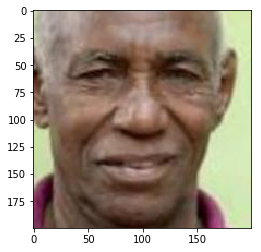

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('utktest/0/65_0_1_20170117194017535.jpg.chip.jpg')
imgplot = plt.imshow(img)
plt.show()

In [28]:
pred=test(args, model, private_test_loader)

tensor([[ 0.0130,  0.0110,  0.1530,  0.1210,  0.0320, -0.0130, -0.0550,  0.0060,
          0.0150,  0.0150,  0.0230, -0.0260, -0.0920,  0.0530,  0.0060,  0.1190,
          0.0240, -0.0170,  0.1530, -0.0560,  0.0470, -0.0260,  0.1100, -0.0320,
         -0.0550, -0.1020,  0.0200,  0.0030,  0.0000,  0.0110, -0.0030,  0.1150,
          0.0250,  0.0190, -0.0780, -0.0940, -0.0010, -0.0460,  0.0750, -0.0560,
          0.0960, -0.0600,  0.0610, -0.0320, -0.0400,  0.0410,  0.0220,  0.0870,
          0.0430,  0.0440, -0.0210,  0.0770, -0.0430,  0.0750, -0.1030, -0.0950,
          0.0390, -0.0240, -0.0350, -0.0990,  0.0020, -0.0700, -0.0320]])


In [29]:
pred

tensor([18])

In [32]:
age = pred+18; age

tensor([36])

as the age at 0th folder is 18, so the predicted age must be pred+18